In [31]:
%matplotlib inline

# Modules
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import scipy as sp

# Data
data_file_path = ''
data_filename = 'spx_history.csv'
processed_data_file = 'processed_data.csv'
model_input_file = 'model_input.csv'
predictions_file = 'predictions.csv'
dt_format = '%Y-%m-%d'
outlier_std = 100

# Investment decision
window = 2500 # days
investment_horizon = 250 # days
stride = 1 #days
mov_avg_period = 5 # days

In [32]:
def get_price_data(filename, dt_format):
    prices = pd.read_csv(filename,
                         delimiter=',',
                         header=0,
                         names=['date', 'P_close'],
                         index_col=0,
                         parse_dates=True,
                         date_parser=lambda date_str: dt.datetime.strptime(date_str, dt_format))
    return prices

In [33]:
def get_processed_data(prices_df, investment_horizon):
    prices_df['log_P'] = prices_df['P_close'].map(np.log)
    prices_df['diff'] = prices_df['log_P'].diff(1)
    outlier_threshold = outlier_std * prices_df['diff'].std()
    prices_df['cleaned'] = prices_df['diff'][prices_df['diff']
                                             .subtract(prices_df['diff'].mean())
                                             .abs()
                                             .lt(outlier_threshold)]
    
    pivot = prices_df['cleaned'].median()
    scale = prices_df['cleaned'].std()
    prices_df['scaled'] = (prices_df['cleaned'] - pivot)/scale

    prices_df['smoothed'] = prices_df['log_P'].rolling(mov_avg_period).min()
    prices_df['roll_max'] = (prices_df['smoothed']
                             .rolling(investment_horizon)
                             .max()
                             .shift(1-investment_horizon))
    prices_df['max_return'] = prices_df['roll_max'].subtract(prices_df['log_P'])

    return prices_df.dropna(), pivot, scale

In [34]:
def save_processed_data(df, filename):
    df.to_csv(filename, sep=',')

In [35]:
full_filename = os.path.join(data_file_path, data_filename)
data = get_price_data(full_filename, dt_format)
processed_data, midpoint, scale = get_processed_data(data, investment_horizon)
save_processed_data(processed_data, processed_data_file)

In [36]:
processed_data.describe()

,P_close,log_P,diff,cleaned,scaled,smoothed,roll_max,max_return
count,22251.000000,22251.000000,22251.000000,22251.000000,22251.000000,22251.000000,22251.000000,22251.000000
mean,378.695350,4.701140,0.000217,0.000217,-0.020649,4.689431,4.839718,0.138578
std,539.889422,1.703756,0.011817,0.011817,1.004597,1.704852,1.689655,0.111641
min,4.400000,1.481605,-0.228997,-0.228997,-19.507468,1.481605,2.169054,-0.056723
25%,22.640000,3.119718,-0.004613,-0.004613,-0.431257,3.108614,3.247658,0.055959
50%,95.790000,4.562158,0.000465,0.000465,0.000488,4.553456,4.653770,0.116761
75%,463.915000,6.139701,0.005398,0.005398,0.419822,6.134785,6.298912,0.202656
max,2182.870000,7.688396,0.153661,0.153661,13.024574,7.680905,7.812095,0.988453


In [37]:
processed_data.head()

,P_close,log_P,diff,cleaned,scaled,smoothed,roll_max,max_return
date,,,,,,,,
1928-01-06,17.66,2.871302,0.006248,0.006248,0.492126,2.865054,3.177220,0.305918
1928-01-09,17.50,2.862201,-0.009101,-0.009101,-0.812830,2.862201,3.188417,0.326216
1928-01-10,17.37,2.854745,-0.007456,-0.007456,-0.672978,2.854745,3.188417,0.333672
1928-01-11,17.35,2.853593,-0.001152,-0.001152,-0.137019,2.853593,3.188417,0.334824
1928-01-12,17.47,2.860485,0.006893,0.006893,0.546908,2.853593,3.188417,0.327931


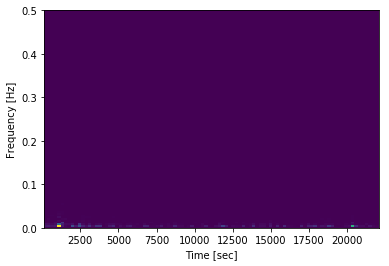

In [87]:
window_length = 2500
f, t, Sxx = sp.signal.spectrogram(processed_data['log_P'].values)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

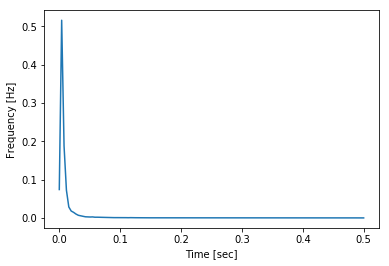

In [82]:
window_length = 250
f, Pxx = sp.signal.welch(processed_data['log_P'].values)
plt.plot(f, Pxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()